In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from envs.forked_riverswim import ForkedRiverSwim
from envs.riverswim import RiverSwim
from typing import Sequence, Dict, Tuple, Union, Literal, NamedTuple
from itertools import product
from numpy.typing import NDArray
import torch
import lzma
import pyximport
_ = pyximport.install(setup_args={"include_dirs":np.get_include()}, reload_support=True)
from utils.cutils import policy_evaluation
from utils.utils import Results
from utils.new_mdp_description import NewMDPDescription
from scipy.stats import t
from make_agent import AgentType
from simulation_parameters import EnvType, SimulationParameters


def TV(p,q):
    return np.sum(np.abs(p-q), -1) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

    
compute_dist_omega = lambda x,y: TV(x,y)
compute_dist_value = lambda V, mdp: np.linalg.norm(V -mdp.V_greedy[np.newaxis, np.newaxis], axis=-1)

In [2]:
import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})

In [9]:
lengths = [
    (5, EnvType.RIVERSWIM),
    (10, EnvType.RIVERSWIM),
    (20, EnvType.RIVERSWIM),
    (3, EnvType.FORKED_RIVERSWIM),
    (5, EnvType.FORKED_RIVERSWIM),
    (10, EnvType.FORKED_RIVERSWIM),
    # (30, EnvType.RIVERSWIM),
    # (15, EnvType.FORKED_RIVERSWIM),
    ]
agents = [AgentType.Q_UCB, AgentType.Q_LEARNING,  AgentType.BAYESOBPI, AgentType.PSRL,
         AgentType.OBPI, AgentType.MDP_NAS, AgentType.BPI_NEW_BOUND, AgentType.BPI_NEW_BOUND_SIMPLIFIED_1, AgentType.BPI_NEW_BOUND_BAYES
        ]


class SequencedResults(NamedTuple):
    omega: NDArray[np.float64]
    greedy_policy: NDArray[np.int64]
    total_state_visits: NDArray[np.float64]
    last_visit: NDArray[np.float64]
    exp_visits: NDArray[np.float64]
    eval_greedy: NDArray[np.float64]
    dist_omega: NDArray[np.float64]
    U_omega: NDArray[np.float64]
    dist_value: NDArray[np.float64]
    elapsed_times: NDArray[np.float64]
    simulation_parameters: SimulationParameters


data: Dict[Tuple[int, EnvType, AgentType],  SequencedResults] = {}
for env_type, agent in product(lengths, agents):
    length, env = env_type
    data[(length, env, agent)] = None
    
        
    with lzma.open(f'data/ntosoold/{env.value}/{agent.value}_{length}.pkl.lzma', 'rb') as f:
        res  = pickle.load(f)
        data[(length, env, agent)] = res



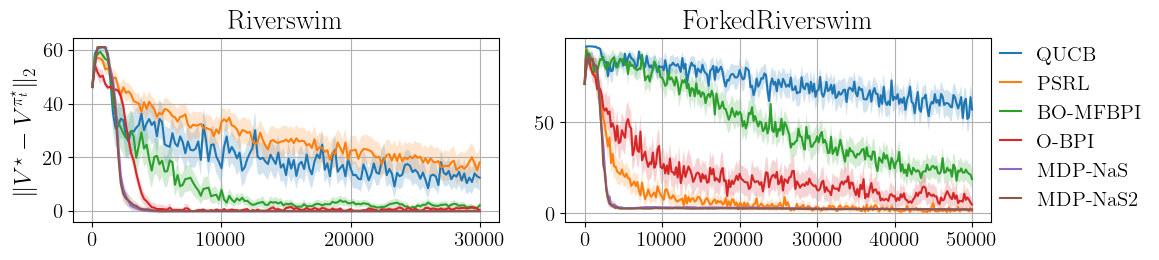

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

labels = {
    AgentType.Q_UCB: "QUCB", 
    AgentType.BAYESOBPI: "BO-MFBPI", 
    AgentType.PSRL: "PSRL",
    AgentType.OBPI: "O-BPI",
    AgentType.MDP_NAS: "MDP-NaS",
    AgentType.BPI_NEW_BOUND: "MDP-NaS2"
}
linestyle = {
    AgentType.Q_UCB: "solid", 
    AgentType.BAYESOBPI: "solid", 
    AgentType.PSRL: "solid",
    AgentType.OBPI: "solid",
    AgentType.MDP_NAS: "solid",
    AgentType.BPI_NEW_BOUND: "solid"
}

id_l = 0
for length, env_type in [(10, EnvType.RIVERSWIM), (10, EnvType.FORKED_RIVERSWIM)]:
    id_e = 0 if env_type == EnvType.RIVERSWIM else 1
    for agent in  [AgentType.Q_UCB,  AgentType.PSRL, AgentType.BAYESOBPI, 
         AgentType.OBPI, AgentType.MDP_NAS, AgentType.BPI_NEW_BOUND     ]:
        parameters=  data[(length, env_type, agent)].simulation_parameters
        x = range(0, parameters.horizon + 1, parameters.frequency_evaluation)

        mu, ce = CE(data[(length, env_type, agent)].dist_value)
        ax[id_e].plot(x, mu, label=labels[agent], linestyle=linestyle[agent])
        ax[id_e].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[id_e].grid()
    ax[id_e].set_title(f'{env_type.value}')


ax[1].legend(ncols=1, handlelength=1,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)
ax[0].set_ylabel('$\|V^\star - V^{\pi_t^\star}\|_2$')
plt.tight_layout()
plt.savefig('figures/performance.pdf')
plt.show()


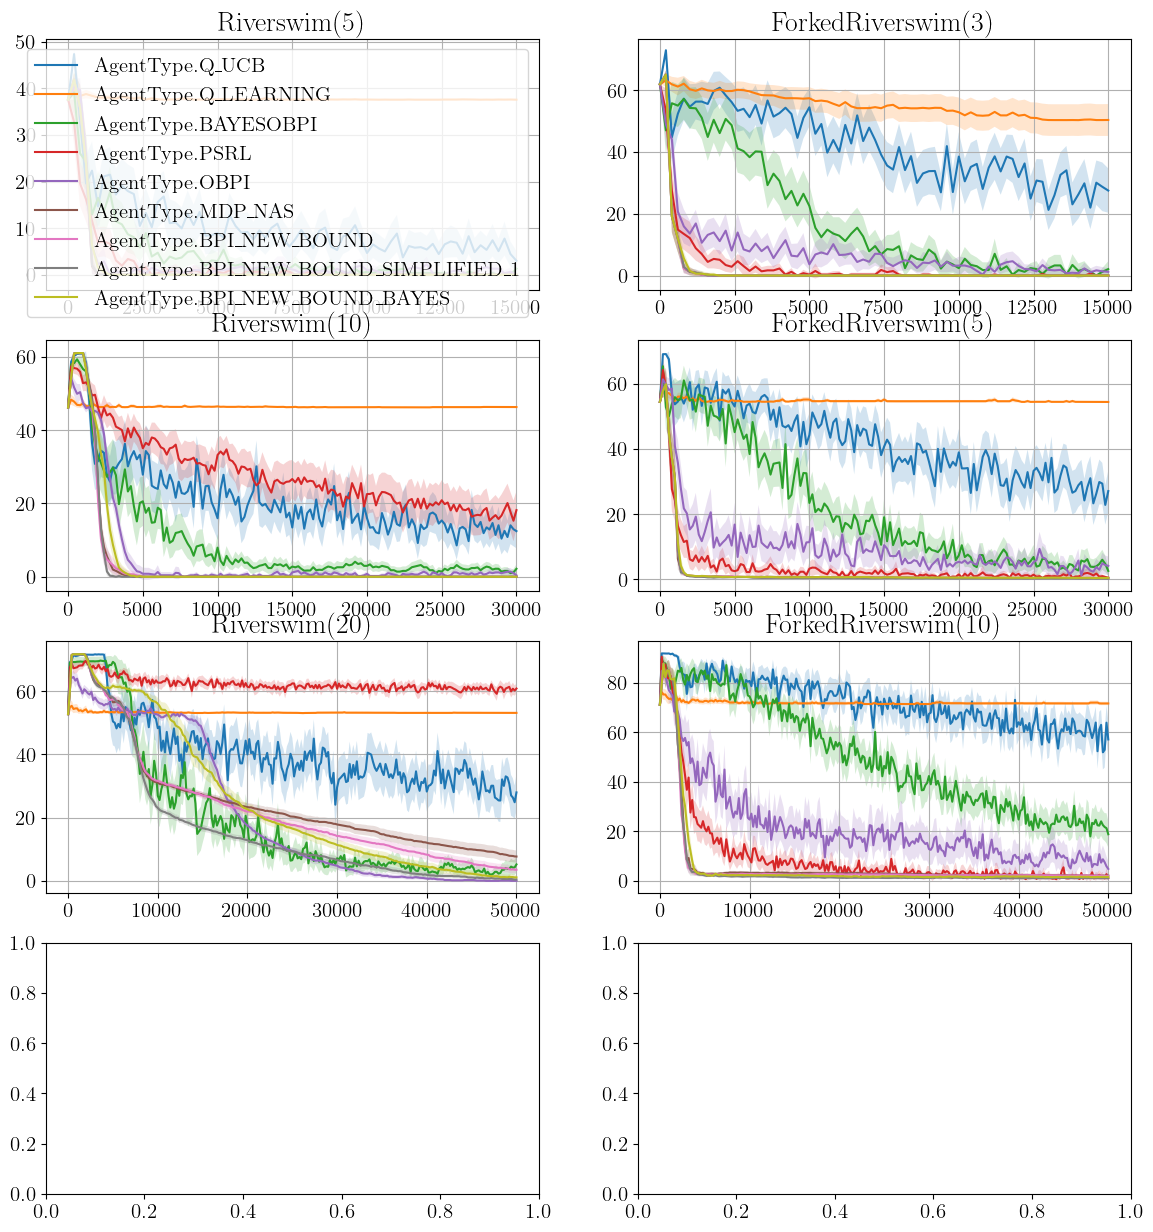

In [10]:
fig, ax = plt.subplots(4, 2, figsize=(14, 15))

id_l = 0
for length, env_type in lengths:
    id_e = 0 if env_type == EnvType.RIVERSWIM else 1
    if env_type == EnvType.RIVERSWIM:
        id_l = 0 if length == 5 else 1 if length == 10 else 2 if length == 20 else 3
    else:
        id_l = 0  if length == 3 else 1 if length == 5 else 2 if length == 10 else 3
    for agent in agents:
        parameters=  data[(length, env_type, agent)].simulation_parameters
        x = range(0, parameters.horizon + 1, parameters.frequency_evaluation)

        mu, ce = CE(data[(length, env_type, agent)].dist_value)
        ax[id_l, id_e].plot(x, mu, label=agent)
        ax[id_l, id_e].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[id_l, id_e].grid()
    ax[id_l, id_e].set_title(f'{env_type.value}({length})')

ax[0,0].legend()
ax[0, 0].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')
plt.show()


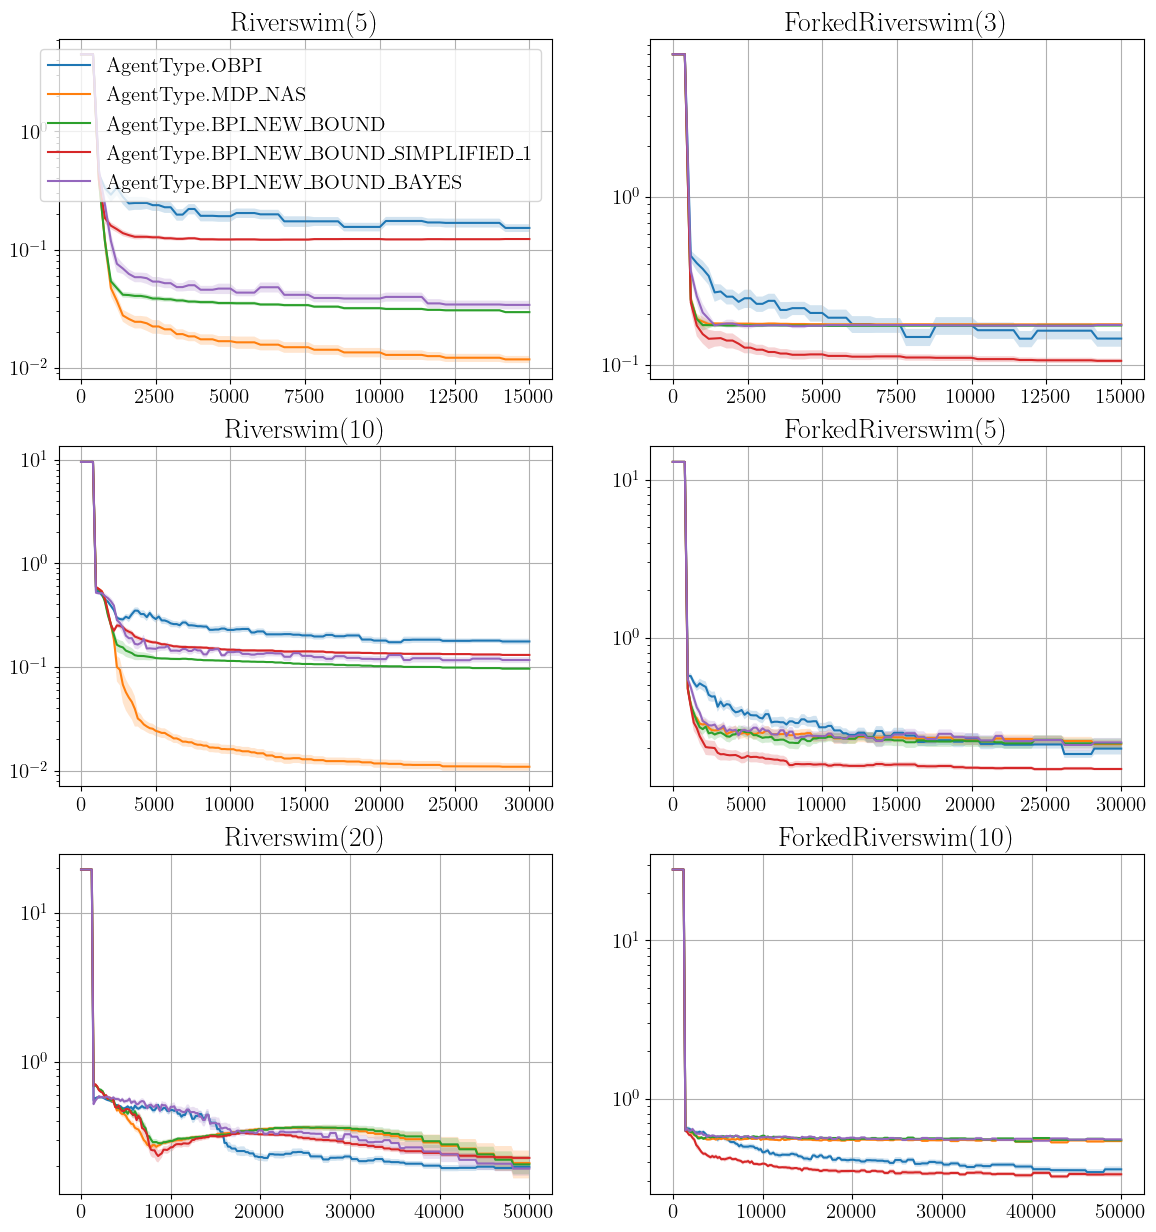

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(14, 15))

id_l = 0
for length, env_type in lengths:
    id_e = 0 if env_type == EnvType.RIVERSWIM else 1
    if env_type == EnvType.RIVERSWIM:
        id_l = 0 if length == 5 else 1 if length == 10 else 2 if length == 20 else 3
    else:
        id_l = 0  if length == 3 else 1 if length == 5 else 2 if length == 10 else 3
    for agent in [AgentType.OBPI, AgentType.MDP_NAS, AgentType.BPI_NEW_BOUND, AgentType.BPI_NEW_BOUND_SIMPLIFIED_1, AgentType.BPI_NEW_BOUND_BAYES]:
        parameters=  data[(length, env_type, agent)].simulation_parameters
        x = range(0, parameters.horizon + 1, parameters.frequency_evaluation)

        mu, ce = CE(data[(length, env_type, agent)].dist_omega)
        ax[id_l, id_e].plot(x, mu, label=agent)
        ax[id_l, id_e].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[id_l, id_e].grid()
    ax[id_l, id_e].set_yscale('log')
    ax[id_l, id_e].set_title(f'{env_type.value}({length})')

ax[0,0].legend()
# ax[0, 0].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')
# ax[0, 1].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')



# for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPI-GEN',  'QLEARNING', 'QUCB', 'MFBPIUCB']:
#     mu, ce = CE(results[agent].dist_value)
#     ax[0].plot(x, mu, label=agent)
#     ax[0].fill_between(x, mu-ce, mu+ce, alpha=0.2)
#     ax[0].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')

# for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPIUCB']:    
#     mu, ce = CE(results[agent].dist_omega)
#     ax[1].plot(x, mu, label=agent)
#     ax[1].fill_between(x, mu-ce, mu+ce, alpha=0.2)
#     ax[1].set_title(r'$TV(\omega_t,\omega_{nc}^\star)$')

# ax[1].set_yscale('log')


# for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPIUCB']:
#     mu, ce = CE(np.log10(results[agent].U_omega  / U))
#     ax[2].plot(x, mu, label=agent)
#     ax[2].fill_between(x, mu-ce, mu+ce, alpha=0.2)
#     ax[2].set_title(r'$U(\omega_t)/U(\omega_{nc}^\star)$')
# #ax[2].set_yscale("log")

# for i in range(3):
#     ax[i].set_xlabel('$t$')
#     ax[i].grid()

# ax[0].legend(ncols=7, bbox_to_anchor=(3.5, -0.2), frameon=False,fontsize=14, borderpad=0.1, labelspacing=0.1, handlelength=1)
# plt.savefig('figures/plot29.pdf')
plt.show()
